In [1]:
import os
import sys
!export PYTHONPATH="${PYTHONPATH}:~/gt/3D_tracking/DEV/Tracking/nuscenes"
import numpy as np

from sklearn.utils.linear_assignment_ import linear_assignment

from nuscenes import NuScenes
from nuscenes.eval.common.config import config_factory
from nuscenes.eval.tracking.evaluate import TrackingEval
from nuscenes.eval.detection.data_classes import DetectionConfig
from nuscenes.eval.detection.data_classes import DetectionBox
from nuscenes.eval.tracking.data_classes import TrackingBox
from nuscenes.eval.common.loaders import load_prediction, load_gt, filter_eval_boxes
from nuscenes.eval.tracking.loaders import create_tracks
from pyquaternion import Quaternion
#from main import iou3d, convert_3dbox_to_8corner
import argparse
import pickle 
from utils.dict import *
from utils.stats import add_center_dist
%load_ext autoreload
%autoreload 2

Loading NuScenes tables for version v1.0-test...
23 category,
8 attribute,
4 visibility,
0 instance,
12 sensor,
1800 calibrated_sensor,
462901 ego_pose,
15 log,
150 scene,
6008 sample,
462901 sample_data,
0 sample_annotation,
4 map,
Done loading in 8.477 seconds.
Reverse indexing ...
Done reverse indexing in 1.9 seconds.
/media/liangxu/ArmyData/nuscenes/trainval/v1.0-test


In [3]:
detection_file = os.path.join(detection_path , 'megvii_train.json')
data_root      = os.path.join(nuscense_path , 'trainval')
gt_boxes_file_name = "/media/liangxu/ArmyData/nuscenes/Tracking_result/tracking_tmp/gt_boxes"
prediction_file_name = "/media/liangxu/ArmyData/nuscenes/Tracking_result/tracking_tmp/pred_boxes"
prediction_file_name_centerpoint = "/media/liangxu/ArmyData/nuscenes/Tracking_result/tracking_tmp/pred_boxes_centerpoint"
nusc_file_name = "/media/liangxu/ArmyData/nuscenes/Tracking_result/tracking_tmp/nusc.pkl"

In [4]:
# Load the detection and ground truth result
nusc = pickle.load(open(nusc_file_name , 'rb'))
#pred_boxes = pickle.load(open(prediction_file_name , 'rb'))
pred_boxes_new = pickle.load(open(prediction_file_name_centerpoint , 'rb'))
gt_boxes   = pickle.load(open(gt_boxes_file_name , 'rb'))

In [5]:
# load the predictions and the gt boxes
"""
version='v1.0-trainval'
nusc = NuScenes(version=version, dataroot=data_root, verbose=True)
with open(nusc_file_name, 'wb') as f:
    pickle.dump(nusc, f)

pred_boxes, _ = load_prediction(detection_file, 10000, DetectionBox)
gt_boxes = load_gt(nusc, 'train', TrackingBox, verbose = True)
with open(prediction_file_name, 'wb') as f:
    pickle.dump(pred_boxes, f)
with open(gt_boxes_file_name, 'wb') as f:
    pickle.dump(gt_boxes, f)

new_prediction_file = "/home/liangxu/gt/3D_tracking/3party/CenterPoint/work_dirs/nusc_centerpoint_voxelnet_dcn_0075voxel_flip_trainSet_new/infos_train_10sweeps_withvelo_filter_True.json"
pred_boxes_new, _ = load_prediction(new_prediction_file, 10000, DetectionBox)
with open(prediction_file_name_centerpoint, 'wb') as f:
    pickle.dump(pred_boxes_new, f)
    
# get the test file
data_root = "/media/liangxu/ArmyData/nuscenes/trainval/v1.0-test"
nusc = NuScenes(version='v1.0-test', dataroot=data_root, verbose=True)
print(data_root)
nusc_test_file_name = "/media/liangxu/ArmyData/nuscenes/Tracking_result/tracking_tmp/nusc_test.pkl"
with open(nusc_test_file_name, 'wb') as f:
    pickle.dump(nusc, f)

"""

"\nversion='v1.0-trainval'\nnusc = NuScenes(version=version, dataroot=data_root, verbose=True)\nwith open(nusc_file_name, 'wb') as f:\n    pickle.dump(nusc, f)\n\npred_boxes, _ = load_prediction(detection_file, 10000, DetectionBox)\ngt_boxes = load_gt(nusc, 'train', TrackingBox, verbose = True)\nwith open(prediction_file_name, 'wb') as f:\n    pickle.dump(pred_boxes, f)\nwith open(gt_boxes_file_name, 'wb') as f:\n    pickle.dump(gt_boxes, f)\n"

In [6]:
#assert set(pred_boxes.sample_tokens) == set(gt_boxes.sample_tokens), \
#            "Samples in split don't match samples in predicted tracks."

assert set(gt_boxes.sample_tokens) == set(pred_boxes_new.sample_tokens), \
            "Samples in split don't match samples in predicted tracks."


In [8]:
 # Add center distances.
#pred_boxes = add_center_dist(nusc, pred_boxes)
pred_boxes_centerpoint = add_center_dist(nusc, pred_boxes_new)
gt_boxes   = add_center_dist(nusc, gt_boxes)

#print('len(pred_boxes.sample_tokens): ', len(pred_boxes.sample_tokens))
print('len(pred_boxes_centerpoint.sample_tokens): ', len(pred_boxes_centerpoint.sample_tokens))
print('len(gt_boxes.sample_tokens): ', len(gt_boxes.sample_tokens))

len(pred_boxes_centerpoint.sample_tokens):  28130
len(gt_boxes.sample_tokens):  28130


In [9]:
tracks_gt = create_tracks(gt_boxes, nusc, 'train', gt=True)

Liang XU


In [17]:

from get_nuscenes_stats import matching_and_get_diff_stats, get_mean
from trainingTestingDataCreating import training_data_creation

In [14]:
get_mean(tracks_gt)

  0%|          | 2/700 [00:00<00:45, 15.27it/s]

len(tracks.keys()):  700


100%|██████████| 700/700 [01:05<00:00, 10.68it/s]


({'bicycle': array([ 1.29255138e+00,  6.04981211e-01,  1.69851979e+00,  9.24922207e+02,
          1.29928737e+03,  7.54455098e-01,  3.50005634e-02,  8.89233002e-03,
         -3.69294743e-02,  1.01596643e-02, -2.28356654e-03,  2.19812316e-03,
         -2.08178349e-03,  2.51023328e-04,  3.81416683e-03]),
  'bus': array([ 3.49466679e+00,  2.94869529e+00,  1.11763184e+01,  1.03657590e+03,
          1.31494559e+03,  1.87588071e+00,  1.75155290e-01,  3.95991159e-02,
         -2.29194236e-02,  6.48864550e-03,  1.83604957e-03, -6.08124866e-03,
          3.70562220e-03,  5.12323703e-04,  3.67486684e-03]),
  'car': array([ 1.73496995e+00,  1.96062873e+00,  4.61921671e+00,  1.18384247e+03,
          1.17948029e+03,  9.67292984e-01,  1.77048395e-01,  1.83719918e-02,
         -1.48373986e-02,  5.44655633e-03,  8.71153712e-04, -7.72651883e-04,
          5.07796695e-04,  4.51635759e-04,  7.76475847e-05]),
  'motorcycle': array([ 1.46360935e+00,  7.76617224e-01,  2.10927549e+00,  9.87766295e+02,
     

In [29]:
matching_and_get_diff_stats(pred_boxes, gt_boxes, tracks_gt, '2d_center')

  0%|          | 0/700 [00:00<?, ?it/s]


IndexError: index 3 is out of bounds for axis 0 with size 3

In [70]:
from get_nuscenes_stats import matching_and_get_diff_stats
matching_and_get_diff_stats(pred_boxes_centerpoint, gt_boxes, tracks_gt, 'advanced')

100%|██████████| 700/700 [08:46<00:00,  1.33it/s]


({'bicycle': array([ 0.00444158,  0.00548391,  0.02700448,  0.00472683,  0.00487179,
          0.00578921, -0.00090104]),
  'bus': array([-0.03849067, -0.02355045,  0.039287  ,  0.0112755 ,  0.00263459,
          0.00761268,  0.00062003]),
  'car': array([-1.33519307e-02, -1.30198578e-02, -1.12860569e-02, -6.58205779e-05,
          2.42299028e-03,  3.80057004e-03, -1.46172755e-03]),
  'motorcycle': array([-0.00109592, -0.00817222, -0.0100901 ,  0.00397068,  0.00278687,
          0.0058704 ,  0.00936965]),
  'pedestrian': array([-0.00331991, -0.0059713 , -0.01035154,  0.00085706,  0.00082741,
          0.00515495,  0.00167351]),
  'trailer': array([ 0.01758176, -0.03357614,  0.0386592 , -0.00047133,  0.00306588,
         -0.0086273 ,  0.00031292]),
  'truck': array([-2.03802520e-02, -3.48075837e-02, -6.75954557e-02, -8.56012919e-05,
         -6.29031429e-03, -4.90164668e-03,  6.46115653e-04])},
 {'bicycle': array([0.15030771, 0.13934666, 0.20774621, 0.22716344, 0.24198294,
         0.16

In [3]:
tracking_diff_file_name = "/media/liangxu/ArmyData/nuscenes/Tracking_result/tracking_tmp/tracking_diff"
tracking_diff = pickle.load(open( tracking_diff_file_name , 'rb'))

In [4]:
diff = {tracking_name: np.stack(tracking_diff[tracking_name], axis=0) for tracking_name in NUSCENES_TRACKING_NAMES}

In [5]:
mean = {tracking_name: np.mean(diff[tracking_name], axis=0) for tracking_name in NUSCENES_TRACKING_NAMES}

In [6]:
for k, v in mean.items(): 
    print(k, v)

bicycle [ 0.00444158  0.00548391  0.02700448  0.00472683  0.00487179  0.00578921
 -0.00090104]
bus [-0.03849067 -0.02355045  0.039287    0.0112755   0.00263459  0.00761268
  0.00062003]
car [-1.33519307e-02 -1.30198578e-02 -1.12860569e-02 -6.58205779e-05
  2.42299028e-03  3.80057004e-03 -1.46172755e-03]
motorcycle [-0.00109592 -0.00817222 -0.0100901   0.00397068  0.00278687  0.0058704
  0.00936965]
pedestrian [-0.00331991 -0.0059713  -0.01035154  0.00085706  0.00082741  0.00515495
  0.00167351]
trailer [ 0.01758176 -0.03357614  0.0386592  -0.00047133  0.00306588 -0.0086273
  0.00031292]
truck [-2.03802520e-02 -3.48075837e-02 -6.75954557e-02 -8.56012919e-05
 -6.29031429e-03 -4.90164668e-03  6.46115653e-04]


In [11]:
std = {tracking_name: np.std(diff[tracking_name], axis=0) for tracking_name in NUSCENES_TRACKING_NAMES}
for k, v in std.items(): 
    print(k, v)

bicycle [0.15030771 0.13934666 0.20774621 0.22716344 0.24198294 0.1652483
 0.22373981]
bus [0.30244347 0.23255523 0.70934273 0.24932923 0.2304485  0.23724314
 0.03879275]
car [0.15910102 0.156636   0.34103986 0.28331662 0.29188843 0.17761093
 0.1081697 ]
motorcycle [0.13264562 0.12467152 0.22833151 0.22237666 0.21442723 0.14621125
 0.18316375]
pedestrian [0.14879412 0.12535981 0.16317245 0.16915797 0.16768133 0.16291298
 0.29450023]
trailer [0.34798771 0.28502763 1.14505057 0.29092018 0.28311265 0.25747015
 0.09652174]
truck [0.29876547 0.24584975 0.84816712 0.30423525 0.30097393 0.22770374
 0.08549889]


In [ ]:
"""
box.size[2], 
box.size[0], 
box.size[1],
box.translation[0], 
box.translation[1], 
box.translation[2],
rotation_to_positive_z_angle(box.rotation)
"""

In [8]:
var = {tracking_name: np.var(diff[tracking_name], axis=0) for tracking_name in NUSCENES_TRACKING_NAMES}
for k, v in var.items(): 
    print(k, v)

bicycle [0.02259241 0.01941749 0.04315849 0.05160323 0.05855574 0.027307
 0.0500595 ]
bus [0.09147205 0.05408194 0.50316711 0.06216506 0.05310651 0.05628431
 0.00150488]
car [0.02531313 0.02453484 0.11630819 0.08026831 0.08519886 0.03154564
 0.01170068]
motorcycle [0.01759486 0.01554299 0.05213528 0.04945138 0.04597904 0.02137773
 0.03354896]
pedestrian [0.02213969 0.01571508 0.02662525 0.02861442 0.02811703 0.02654064
 0.08673039]
trailer [0.12109544 0.08124075 1.3111408  0.08463455 0.08015278 0.06629088
 0.00931645]
truck [0.0892608  0.0604421  0.71938747 0.09255909 0.09058531 0.05184899
 0.00731006]


In [10]:
MeasurementNoise_file_name = "/media/liangxu/ArmyData/nuscenes/Tracking_result/tracking_tmp/measurement_noise_var"
with open(MeasurementNoise_file_name, 'wb') as f:
    pickle.dump(var, f)
    

In [64]:
# plot the histgram
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

bicycle
(7894,)


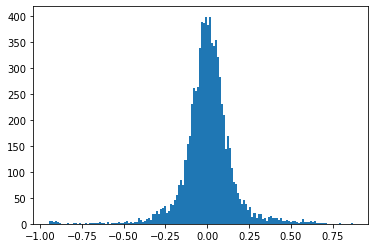

bus
(8541,)


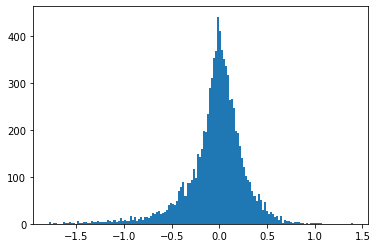

car
(319597,)


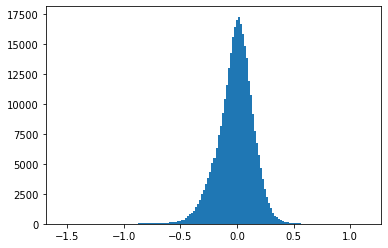

motorcycle
(8495,)


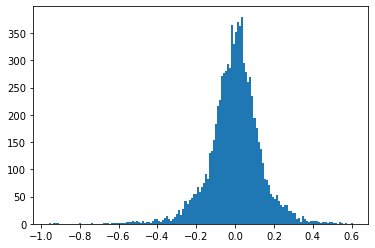

pedestrian
(162985,)


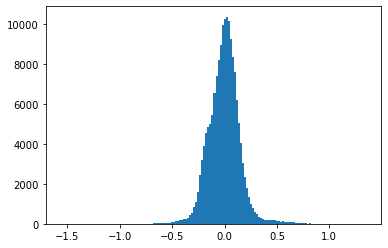

trailer
(13449,)


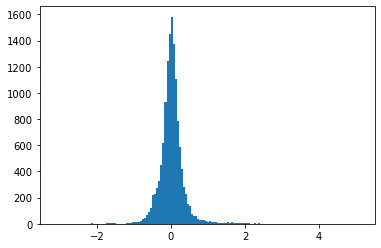

truck
(48851,)


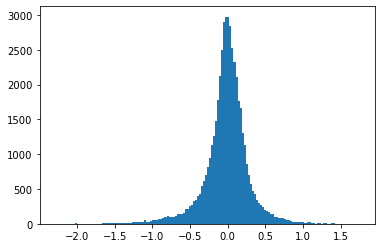

In [67]:
for tracking_name in NUSCENES_TRACKING_NAMES: 
    print(tracking_name)
    values = diff[tracking_name][:,0]
    print(values.shape)
    plt.hist(values, 150)
    plt.show()

## Testing the miss detection rate and clutter rate

In [71]:
miss_detection_rate_file_name = "/media/liangxu/ArmyData/nuscenes/Tracking_result/tracking_tmp/miss_detection_rate"
clutter_rate_file_name = "/media/liangxu/ArmyData/nuscenes/Tracking_result/tracking_tmp/clutter_rate"
miss_detection_rate = pickle.load(open( miss_detection_rate_file_name , 'rb'))
clutter_rate        = pickle.load(open( clutter_rate_file_name , 'rb'))

bicycle
0.17546647823143685


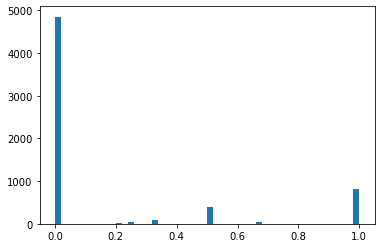

bus
0.22741892512632061


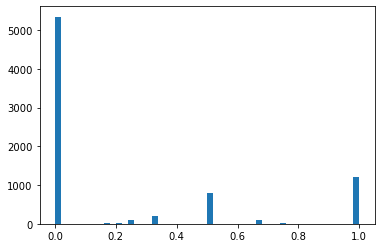

car
0.23008693770454175


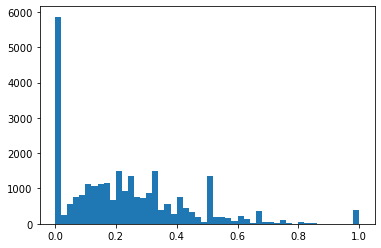

motorcycle
0.17746422387295707


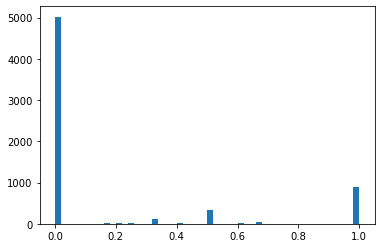

pedestrian
0.14290858673907253


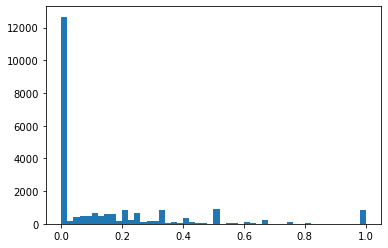

trailer
0.28530788819262637


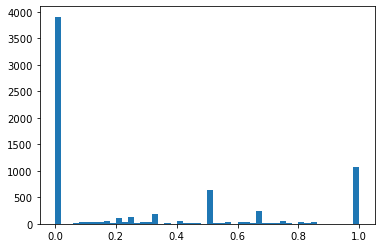

truck
0.3149607594217675


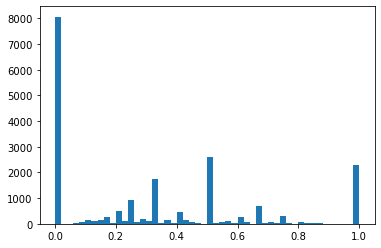

In [79]:
for tracking_name in NUSCENES_TRACKING_NAMES: 
    print(tracking_name)
    values = miss_detection_rate[tracking_name]
    print(np.mean(values))
    plt.hist(values, 50)
    plt.show()

bicycle
0.9115411522704274


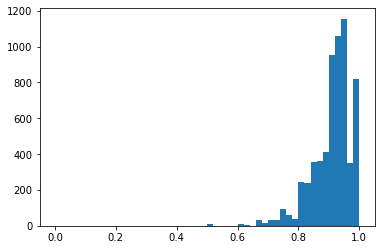

bus
0.3612809676925432


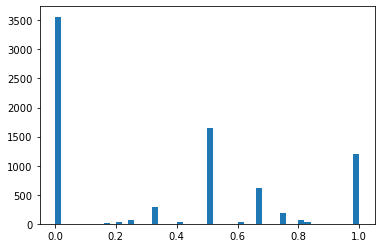

car
0.5401523835124042


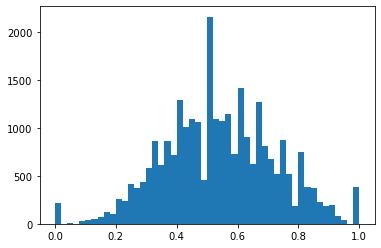

motorcycle
0.8659063094039738


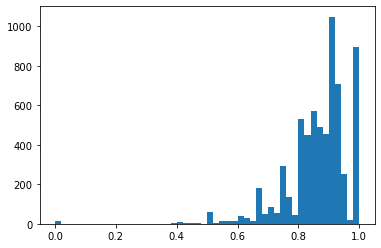

pedestrian
0.7637450814802567


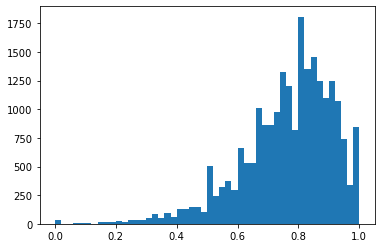

trailer
0.5696673222082385


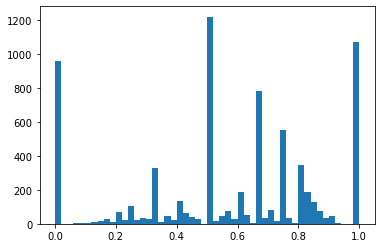

truck
0.7157382173562927


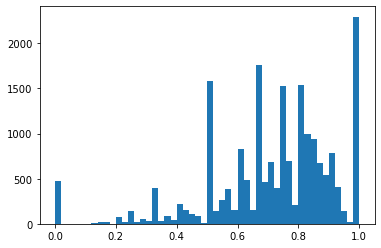

In [80]:
for tracking_name in NUSCENES_TRACKING_NAMES: 
    print(tracking_name)
    values = clutter_rate[tracking_name]
    print(np.mean(values))
    plt.hist(values, 50)
    plt.show()

## Creating the tracking data

In [72]:
training_data_creation(nusc, pred_boxes_centerpoint, gt_boxes, tracks_gt)

  1%|          | 70/7542 [00:00<00:10, 679.28it/s]

Number of instance  64386
total number of data sets  7542


 14%|█▍        | 101/700 [00:00<00:00, 1007.95it/s]

Total Number of tracks  3540
In [  0  ] scene_token  f0f120e4d4b0441da90ec53b16ee169d  has [  41  ] sample
In [  1  ] scene_token  43d5f10c855048b9963c9eb288a8a001  has [  41  ] sample
In [  2  ] scene_token  5c9bd7ead37e4aa9989f7909f3a78baa  has [  40  ] sample
In [  3  ] scene_token  aa54277d163d419b9f952b014112643e  has [  41  ] sample
In [  4  ] scene_token  5890face846e47a899246159b7c30bd7  has [  41  ] sample
In [  5  ] scene_token  e3b6fe9201c64334be311d4249a0c80e  has [  41  ] sample
In [  6  ] scene_token  ae643c14ded14e6ea74f8c8605200ed1  has [  41  ] sample
In [  7  ] scene_token  2538a745a83f430eb590d48b4743e179  has [  40  ] sample
In [  8  ] scene_token  1ec0b9bc3eca4b76b2610c519f843762  has [  40  ] sample
In [  9  ] scene_token  7ed1b613f0ee47ceaf6d19ca3947f825  has [  39  ] sample
In [  10  ] scene_token  b519ec833e23450a8bd3340b67f2516b  has [  41  ] sample
In [  11  ] scene_token  103b54209e584cd4b7ed2890eca2e126  has [  41  ] sample
In [  12  ] scene_token  ea4c4271

 43%|████▎     | 303/700 [00:00<00:00, 971.39it/s] 

 has [  39  ] sample
In [  199  ] scene_token  2575c1870ede486b8568279b4731e47e  has [  41  ] sample
In [  200  ] scene_token  bc8f2774ff4946d3965a807a6aa1b64f  has [  39  ] sample
In [  201  ] scene_token  f7d01e23508040c2aec430e8da13fb76  has [  41  ] sample
In [  202  ] scene_token  1891b66d9f58463399aa242f3b521232  has [  40  ] sample
In [  203  ] scene_token  3b5f3391078e48ac92600cbdfa4ccbe6  has [  40  ] sample
In [  204  ] scene_token  53e8446852bf488bb1b09ae032918bbd  has [  40  ] sample
In [  205  ] scene_token  55c853d5aab04850a8059dc95e62c2ad  has [  40  ] sample
In [  206  ] scene_token  a8bd4c1efe284a5bba46f59454764965  has [  41  ] sample
In [  207  ] scene_token  1466f33b56704942a368fa03d10708dd  has [  40  ] sample
In [  208  ] scene_token  717053dec2ef4baa913ba1e24c09edff  has [  40  ] sample
In [  209  ] scene_token  e15260c4ed5b4505900d497ef92ddd2d  has [  40  ] sample
In [  210  ] scene_token  3014465d5958427aac89c4f15b6050dd  has [  40  ] sample
In [  211  ] scene_

 74%|███████▍  | 519/700 [00:00<00:00, 959.31it/s] 

  ] sample
In [  383  ] scene_token  17302a41218442ffbb0b094adb0669ab  has [  40  ] sample
In [  384  ] scene_token  ef5f216134a94e308697ab4c75402a20  has [  40  ] sample
In [  385  ] scene_token  d9161e521b1644cea4cb9e3f21ef9f79  has [  40  ] sample
In [  386  ] scene_token  affb0caa5d2948f98cee5c42c7aefc1c  has [  41  ] sample
In [  387  ] scene_token  8dd4349e80c345afac455cf76074f028  has [  40  ] sample
In [  388  ] scene_token  3032b651c72e4b5c86d4dea1b4930689  has [  40  ] sample
In [  389  ] scene_token  d95a36c034344ae2ac11daf2ba1b2c60  has [  41  ] sample
In [  390  ] scene_token  373bf99c103d4464a7b963a83523fbcb  has [  41  ] sample
In [  391  ] scene_token  590b4e5a4f94426ab3b1a66f35e140d5  has [  40  ] sample
In [  392  ] scene_token  03ee880dd4e348f4b3407f0d073c7c70  has [  40  ] sample
In [  393  ] scene_token  7365754410624f2f85087003f4ed41ad  has [  40  ] sample
In [  394  ] scene_token  d033fb0d79ea42b9a356fa5162172598  has [  41  ] sample
In [  395  ] scene_token  881

100%|██████████| 700/700 [00:00<00:00, 973.88it/s]

 has [  41  ] sample
In [  592  ] scene_token  8e1f7ff7dc9940da8eeca3c06ae1aa4d  has [  40  ] sample
In [  593  ] scene_token  0c13be31e9854d97960d1af570db433f  has [  40  ] sample
In [  594  ] scene_token  ff6af17f52c34e9c9958c64e41fb3786  has [  40  ] sample
In [  595  ] scene_token  1d25e9071ea94891b5eb7554e77a11bb  has [  40  ] sample
In [  596  ] scene_token  453453c849304ad69741891946d46453  has [  40  ] sample
In [  597  ] scene_token  49eb09ab4c4142268131125d6e619a0c  has [  40  ] sample
In [  598  ] scene_token  d8a5dd6087de4e808c61c27f91e8216e  has [  40  ] sample
In [  599  ] scene_token  60111bb5388f4195b98555d4d4b89618  has [  39  ] sample
In [  600  ] scene_token  2a334f5c4615465f86a250d4758a2d7d  has [  40  ] sample
In [  601  ] scene_token  d4d2faa310a748dda508d15c6d5c4244  has [  40  ] sample
In [  602  ] scene_token  d83994e61a1b431cacf34931801d0c78  has [  40  ] sample
In [  603  ] scene_token  e0a22086a94f48e5bbd4c4e7916b2106  has [  40  ] sample
In [  604  ] scene_